# RadQG Demo
In this notebook, we will demonstrate the main functionalities of the RadQG project in a notebook environment. To work with the GUI application, please run the `app.py` file.

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from IPython.display import Markdown
import os
import sys

sys.path.append("../")
import matplotlib.pyplot as plt
import skimage.io as io
import radqg.configs as configs
from radqg.generator import Generator
from radqg.llm.openai import embed_fn as openai_embed_fn
from radqg.llm.openai import qa as openai_qa

### Extracting the figures and text from HTML files 

Please download your desired articles from the RadioGraphics website as HTML files and put them in the DATA_DIR folder. Do not change the names of the files and folders when saving them from the website. Five sample articles are already provided.

In [4]:
# Listing all the HTML files

DATA_DIR = configs.DATA_DIR

print("Name of the articles: \n")
for file in os.listdir(DATA_DIR):
    if file.endswith(".html"):
        print(file)

Name of the articles: 

MR Imaging Evaluation of Perianal Fistulas_ Spectrum of Imaging Features _ RadioGraphics.html
Gallbladder Carcinoma and Its Differential Diagnosis at MRI_ What Radiologists Should Know _ RadioGraphics.html
Imaging Features of Premalignant Biliary Lesions and Predisposing Conditions with Pathologic Correlation _ RadioGraphics.html
CT and PET in Stomach Cancer_ Preoperative Staging and Monitoring of Response to Therapy _ RadioGraphics.html
Chronic Pancreatitis or Pancreatic Tumor_ A Problem-solving Approach _ RadioGraphics.html
Gastrointestinal Bleeding at CT Angiography and CT Enterography_ Imaging Atlas and Glossary of Terms _ RadioGraphics.html
Imaging and Surgical Management of Anorectal Vaginal Fistulas _ RadioGraphics.html
Pancreatic Neuroendocrine Neoplasms_ 2020 Update on Pathologic and Imaging Findings and Classification _ RadioGraphics.html
Heterotopic Pancreas_ Histopathologic Features, Imaging Findings, and Complications _ RadioGraphics.html
Liver Meta

### Create a QA generator

Creating the QA generator is the first step in the pipeline. In addition to the path to the directory containing the HTML files, we need to specify an embedding function (e.g., from OpenAI), and the chunk_size and chunk_overlap values that should be used for splitting the articles into chunks. The latter two could be changed in the notebook or in the `config.py` file.

The next step is to setup the generator. This step will return all the article names, paths to figures detected for the articles, their captions, and also a Python sampler for selecting random figures as the source for question generation. The user can specify a word or phrase as the interested `topic` when setting up the question bank for the generator. If provided, then the QA generator will be more inclined to select figures as the source for question genenration that have haptions related to the topic. Otherwise, the generator will pick completely random figures for question generation.

In [5]:
# Setting up the generator

generator = Generator(
    data_dir=DATA_DIR,
    embed_fn=openai_embed_fn,
    chunk_size=configs.CHUNK_SIZE,
    chunk_overlap=configs.CHUNK_OVERLAP,
)

topic = None
article_names, figpaths, captions, sampler = generator.setup_qbank(topic)

The collection "20231123_120657" has been created with:
    348 figures from 10 articles


### Figure selection
The next step is selecting a random figure. When the figure is selected, the name of the article containing the figure, the path to the figure, and the caption of the figure will be returned.

In [6]:
article_name, figpath, caption = generator.select_figure(
    article_names, figpaths, captions, sampler, reset_memory=False
)
print("Article name: ", article_name)
print("Figure path: ", figpath)
print("Caption: ", caption)

Article name:  Imaging and Surgical Management of Anorectal Vaginal Fistulas _ RadioGraphics.html
Figure path:  /research/projects/m221279_Pouria/RadQG/data/html_articles/Top_10_GI_R4/Imaging and Surgical Management of Anorectal Vaginal Fistulas _ RadioGraphics_files/images_medium_rg.2018170167.fig9c.gif
Caption:  Figure 9c.Rectal adenocarcinoma invading the vagina in a 57-year-old woman.(a, b)Sagittal(a)and axial(b)T2-weighted MR images show a heterogeneous predominantly T2-hyperintense rectal mass invading the middle to upper region of the vagina and thus causing an enormous fistula (☆). The patient underwent radiation therapy.(c)Subsequently obtained axial T2-weighted MR image shows a marked treatment response in the tumor (arrow). Persistence of the fistula resulted in a loss of substantial portions of the right lateral and anterior rectal walls, with destruction of the vagina and right piriformis muscle. Permanent diverting colostomy was recommended; however, the patient selected 

#### Generate a question

The final step is to generate the question. The user should specify a question/answering function (e.g., from OpenAI), the name of the article containing the figure, and the caption of the figure. The question/answering function will return a Python dictionary containing the question and an answer to the questio. Optionally, the generator could also return a subset of the article text (referred to as `context`) that was extracted from the article and the LLM used it for developing a better question from the figure.
> Note: The type_of_question could be one of ["MCQ" or "Short-Answer"].


---------Round 1---------

Radiologist output: Radiologist > Question stem:
A 57-year-old woman, previously treated with radiation therapy for rectal adenocarcinoma, presents with a history of incontinence. An axial T2-weighted MR image (Fig 9c) shows a marked treatment response in the tumor. However, there is persistence of a fistula and loss of substantial portions of the right lateral and anterior rectal walls, with destruction of the vagina and right piriformis muscle. Based on the figure and the patient's clinical history, what is the most likely recommendation for this patient?
Options:
{'A': 'Immediate surgical intervention', 'B': 'Resection and primary anastomosis', 'C': 'Permanent diverting colostomy', 'D': 'Endoscopic assessment and potentially biopsy', 'E': 'Continuation of radiation therapy'}
Answer:
C: Permanent diverting colostomy
Educationist > Status: Fail: The question stem discloses specific imaging findings from the figure caption. The question stem should not revea




Final Question:
 
A 57-year-old woman, previously treated with radiation therapy for rectal adenocarcinoma, presents with a history of incontinence. Based on the provided figure and the patient's clinical history, what is the most likely recommendation for this patient?

Options:

- A) Immediate surgical intervention
- B) Resection and primary anastomosis
- C) Permanent diverting colostomy
- D) Endoscopic assessment and potentially biopsy
- E) Continuation of radiation therapy

Answer:

C: Permanent diverting colostomy. The figure shows that despite the marked treatment response in the tumor due to radiation therapy, there is persistence of the fistula and loss of substantial portions of the right lateral and anterior rectal walls, with destruction of the vagina and right piriformis muscle. This indicates that the fistula has not healed, and the patient continues to suffer from incontinence. Hence, a permanent diverting colostomy, which would reroute the bowel through an opening in the abdomen, is likely to be recommended to manage her symptoms. The other options are less likely because they either involve additional invasive procedures (A and B) that may not be necessary given the treatment response, or they don't address the ongoing issue of incontinence (D and E).

Figure Caption:

Figure 9c.Rectal adenocarcinoma invading the vagina in a 57-year-old woman.(a, b)Sagittal(a)and axial(b)T2-weighted MR images show a heterogeneous predominantly T2-hyperintense rectal mass invading the middle to upper region of the vagina and thus causing an enormous fistula (☆). The patient underwent radiation therapy.(c)Subsequently obtained axial T2-weighted MR image shows a marked treatment response in the tumor (arrow). Persistence of the fistula resulted in a loss of substantial portions of the right lateral and anterior rectal walls, with destruction of the vagina and right piriformis muscle. Permanent diverting colostomy was recommended; however, the patient selected incontinence rather than diversion.


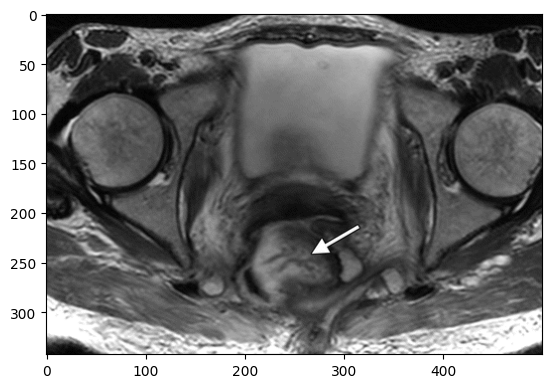

In [11]:
qa_json, *logs = generator.generate_qa(
    qa_fn=openai_qa,
    article_name=article_name,
    figpath=figpath,
    caption=caption,
    type_of_question="MCQ",
    complete_return=True,
)

figure = io.imread(figpath).squeeze()
plt.imshow(figure)
text_to_display = f"""

\nFinal Question:\n 
{qa_json['question']}
\nOptions:\n
- A) {qa_json['options']['A']}
- B) {qa_json['options']['B']}
- C) {qa_json['options']['C']}
- D) {qa_json['options']['D']}
- E) {qa_json['options']['E']}
\nAnswer:\n
{qa_json['answer']}
\nFigure Caption:\n
{caption}
"""

Markdown(text_to_display)